# Demo


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
from datetime import datetime

from ast import literal_eval

from scipy.cluster import hierarchy
from scipy.spatial import distance

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score,mean_absolute_error

import glob, os    

target = 'fut_lag2_return_20'


i = "stock/000002SZ.csv"
stockCode = i[-12:-4]

    

stock1 = pd.read_csv(i)
stock1 = stock1[['trade_date','close','vol']]
stock1['trade_date'] = stock1['trade_date'].astype('str').apply(lambda x: datetime.strptime(x, "%Y%m%d"))
stock1 = stock1.set_index('trade_date')
stock1 = stock1.sort_index()
stock1 = stock1.fillna(method='ffill')



In [2]:
kw = pd.read_csv('news_sent_kw_tag.csv')

In [3]:
### Price Feature Matrix

# pct change
stock1['past_ret_1'] = stock1.close.pct_change(1) # past day's returns
stock1['past_ret_5'] = stock1.close.pct_change(5) # past week's returns
stock1['past_ret_10'] = stock1.close.pct_change(10) # past two weeks' returns
stock1['past_ret_20'] = stock1.close.pct_change(20) # past month's (approx) returns
stock1['logVol'] = stock1.vol.apply(np.log)
stock1['past_logVol_1'] = stock1.logVol.pct_change(1) # past day's change of log volume
stock1['past_logVol_5'] = stock1.logVol.pct_change(5) # past week's change of log volume
stock1['past_logVol_10'] = stock1.logVol.pct_change(10) # past two weeks' change of log volume
stock1['past_logVol_20'] = stock1.logVol.pct_change(20) # past month's change of log volume


# rolling mean or std
stock1['roll_Close_Mean_200'] = stock1['close'].rolling(window=200, min_periods=20).mean().shift(1)
stock1['roll_Close_Std_200'] = stock1['close'].rolling(window=200, min_periods=20).std().shift(1)
stock1['roll_LogVol_Mean_200'] = stock1['logVol'].rolling(window=200, min_periods=20).mean().shift(1)
stock1['roll_LogVol_Std_200'] = stock1['logVol'].rolling(window=200, min_periods=20).std().shift(1)


# z-score
stock1['zscore_price'] = (stock1['close'] - stock1['roll_Close_Mean_200'] ) / stock1['roll_Close_Std_200'] 
stock1['zscore_logVol'] = (stock1['logVol'] - stock1['roll_LogVol_Mean_200'] ) / stock1['roll_LogVol_Std_200'] 

# change sign
stock1['sign_LogVol_1'] = stock1['past_logVol_1'].apply(np.sign)
stock1['sign_Ret_1'] = stock1['past_ret_1'].apply(np.sign)

### Outcome Feature

out_stock1 = pd.DataFrame(index = stock1.index)

### Pct Change

### Assume T+1 enter the market
out_stock1['fut_lag1_return_1'] = stock1.close.pct_change(1).shift(-1-1) # next day's returns
out_stock1['fut_lag1_return_5'] = stock1.close.pct_change(5).shift(-1-5) # next week's returns
out_stock1['fut_lag1_return_10'] = stock1.close.pct_change(10).shift(-1-10) # next two weeks' returns
out_stock1['fut_lag1_return_20'] = stock1.close.pct_change(20).shift(-1-20) # next month's (approx) returns
### Assume T+2 enter the market
out_stock1['fut_lag2_return_1'] = stock1.close.pct_change(1).shift(-2-1) # next day's returns
out_stock1['fut_lag2_return_5'] = stock1.close.pct_change(5).shift(-2-5) # next week's returns
out_stock1['fut_lag2_return_10'] = stock1.close.pct_change(10).shift(-2-10) # next two weeks' returns
out_stock1['fut_lag2_return_20'] = stock1.close.pct_change(20).shift(-2-20) # next month's (approx) returns

### Direction/sign

### Assume T+1 enter the market
out_stock1['fut_lag1_sign_1'] = np.sign(out_stock1['fut_lag1_return_1']) # next day's returns
out_stock1['fut_lag1_sign_5'] = np.sign(out_stock1['fut_lag1_return_5']) # next week's returns
out_stock1['fut_lag1_sign_10'] = np.sign(out_stock1['fut_lag1_return_10']) # next two weeks' returns
out_stock1['fut_lag1_sign_20'] = np.sign(out_stock1['fut_lag1_return_20']) # next month's (approx) returns
### Assume T+2 enter the market
out_stock1['fut_lag2_sign_1'] = np.sign(out_stock1['fut_lag2_return_1']) # next day's returns
out_stock1['fut_lag2_sign_5'] = np.sign(out_stock1['fut_lag2_return_5']) # next week's returns
out_stock1['fut_lag2_sign_10'] = np.sign(out_stock1['fut_lag2_return_10']) # next two weeks' returns
out_stock1['fut_lag2_sign_20'] = np.sign(out_stock1['fut_lag2_return_20']) # next month's (approx) returns

### News Feature Matrix

news = pd.read_csv('dummy_matrix.csv').drop('Unnamed: 0', axis =1)
news['date'] =  pd.to_datetime(news['date'], format='%Y-%m-%d')

# The keywords of news
news_keywords = pd.read_csv('news_sent_kw_tag.csv')[['date', 'keywords']]

# The keywords of the companys
stock_keywords = pd.read_csv('stock_keywords.csv')
stock_keywords['keywords'] = stock_keywords['keywords'].apply(literal_eval)
    # should specify which one
keyword1 = stock_keywords[stock_keywords['code'] == stockCode ]['keywords'].iloc[0]

# Find those relevant news for this compnay

news_keywords['relevant'] = news_keywords['keywords'].apply(lambda x: any([word in x for word in keyword1]))

### Relevant News
test = news.iloc[news_keywords[news_keywords['relevant']].index]
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')

### Summarise the News on that date
groupbyNews = test.groupby('date').agg({'lv1_tag_国际': 'sum',
 'lv1_tag_时事': 'sum',
 'lv1_tag_社会': 'sum',
 'lv1_tag_财经': 'sum',
 'sentiment_pos': 'mean',
 'dayofweek_1': 'mean',
 'dayofweek_2': 'mean',
 'dayofweek_3': 'mean',
 'dayofweek_4': 'mean',
 'dayofweek_5': 'mean',
 'dayofweek_6': 'mean',
 'quarter_2': 'mean',
 'quarter_3': 'mean',
 'quarter_4': 'mean',
 'month_2': 'mean',
 'month_3': 'mean',
 'month_4': 'mean',
 'month_5': 'mean',
 'month_6': 'mean',
 'month_7': 'mean',
 'month_8': 'mean',
 'month_9': 'mean',
 'month_10': 'mean',
 'month_11': 'mean',
 'month_12': 'mean',})

# The preditive feature matrix

feature1 = groupbyNews.join(stock1, how = 'inner')

### Standardize predictive features
std_scaler = StandardScaler()
features_scaled = std_scaler.fit_transform(feature1.dropna()) 

df = pd.DataFrame(features_scaled,index=feature1.dropna().index)
df.columns = feature1.dropna().columns


/home/Rex/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/Rex/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/Rex/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [4]:
# dropna
outcome_scaled = out_stock1.dropna()

### Find the indices that both feature matrix and the outcome matrix share
index = df.index.intersection(outcome_scaled[target].index)

out = outcome_scaled[target].loc[index]
df = df.loc[index]


In [5]:
### Feature Selection

corr = df.corrwith(out)
selected_features = corr[abs(corr)>0.1].sort_values(ascending=False).index.tolist()
print("Features selected: ")
print(corr[abs(corr)>0.1])

Features selected: 
quarter_4               0.138923
month_11                0.176101
close                  -0.128587
past_ret_10            -0.148962
past_ret_20            -0.146508
roll_Close_Std_200     -0.183224
roll_LogVol_Mean_200    0.101641
roll_LogVol_Std_200     0.164967
dtype: float64


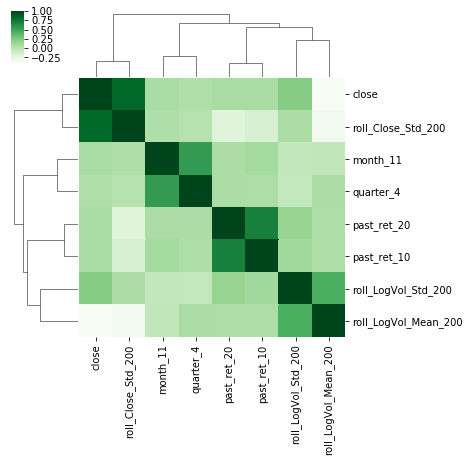

In [6]:
corr_matrix = df[selected_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns

In [7]:
X = df[selected_features]
y = out

In [8]:
def make_walkforward_model(features,outcome,algo=LinearRegression()):
    recalc_dates = features.resample('Y').mean().index.values[:-1]
    
    ## Train models
    models = pd.Series(index=recalc_dates)
    for date in recalc_dates:    
        X_train = features.loc[slice(None,date)]
        y_train = outcome.loc[slice(None,date)]
#         print(f'Train with data prior to: {date} ({y_train.count()} obs)')
        
        model = clone(algo)
        model.fit(X_train,y_train)
        models.loc[date] = model

    begin_dates = models.index
    end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

    ## Generate OUT OF SAMPLE walk-forward predictions
    predictions = pd.Series(index=features.index)
    for i,model in enumerate(models): #loop thru each models object in collection
#         print(f'Using model trained on {begin_dates[i]}, Predict from: {begin_dates[i]} to: {end_dates[i]}')
        X = features.loc[slice(begin_dates[i],end_dates[i])]
        p = pd.Series(model.predict(X),index=X.index)
        predictions.loc[X.index] = p
    
    return models,predictions

def prepare_Xy(X_raw,y_raw):
    ''' Utility function to drop any samples without both valid X and y values'''
    Xy = X_raw.join(y_raw).replace({np.inf:None,-np.inf:None}).dropna()
    X = Xy.iloc[:,:-1]
    y = Xy.iloc[:,-1]
    return X,y

In [9]:
linear_models,linear_preds = make_walkforward_model(X,y,algo=LinearRegression())
tree_models,tree_preds = make_walkforward_model(X,y,algo=ExtraTreesRegressor())


X_ens, y_ens = prepare_Xy(X_raw=pd.concat([linear_preds.rename('linear'),tree_preds.rename('tree')],
                                          axis=1),y_raw=y)

ensemble_models,ensemble_preds = make_walkforward_model(X_ens,y_ens,algo=LassoCV(positive=True))
ensemble_preds = ensemble_preds.rename('ensemble')



/home/Rex/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/Rex/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/Rex/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/Rex/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/Rex/anaconda3/lib/python3.6/site-packages/sklearn/

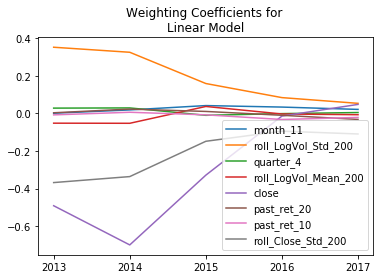

In [10]:
pd.DataFrame([model.coef_ for model in linear_models],
             columns=X.columns,index=linear_models.index).plot(title='Weighting Coefficients for \nLinear Model')

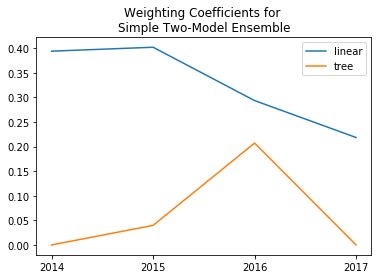

In [11]:
pd.DataFrame([model.coef_ for model in ensemble_models],
             columns=X_ens.columns,index=ensemble_models.index).plot(title='Weighting Coefficients for \nSimple Two-Model Ensemble')

In [12]:
def calc_scorecard(y_pred,y_true):
    
    def make_df(y_pred,y_true):
        y_pred.name = 'y_pred'
        y_true.name = 'y_true'

        df = pd.concat([y_pred,y_true],axis=1).dropna()

        df['sign_pred'] = df.y_pred.apply(np.sign)
        df['sign_true'] = df.y_true.apply(np.sign)
        df['is_correct'] = 0
        df.loc[df.sign_pred * df.sign_true > 0 ,'is_correct'] = 1 # only registers 1 when prediction was made AND it was correct
        df['is_incorrect'] = 0
        df.loc[df.sign_pred * df.sign_true < 0,'is_incorrect'] = 1 # only registers 1 when prediction was made AND it was wrong
        df['is_predicted'] = df.is_correct + df.is_incorrect
        df['result'] = df.sign_pred * df.y_true 
        return df
    
    df = make_df(y_pred,y_true)
    
    scorecard = pd.Series()
    
    # building block metrics
#     scorecard.loc['RSQ'] = r2_score(df.y_true,df.y_pred)
#     scorecard.loc['MAE'] = mean_absolute_error(df.y_true,df.y_pred)
    scorecard.loc['directional_accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scorecard.loc['edge'] = df.result.mean()
#     scorecard.loc['noise'] = df.y_pred.diff().abs().mean()
    # derived metrics
    
    scorecard.loc['edge_long'] = df[df.sign_pred == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_short'] = df[df.sign_pred == -1].result.mean()  - df.y_true.mean()

    scorecard.loc['edge_win'] = df[df.is_correct == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_lose'] = df[df.is_incorrect == 1].result.mean()  - df.y_true.mean()

    
#     scorecard.loc['edge_to_noise'] = scorecard.loc['edge'] / scorecard.loc['noise']
#     scorecard.loc['edge_to_mae'] = scorecard.loc['edge'] / scorecard.loc['MAE']

    
    return scorecard    




Here is the result of *New China Life Insurance (601336.SH)*:

In [13]:
# calculate scores for each model
score_ens = calc_scorecard(y_pred=ensemble_preds,y_true=y_ens).rename('Ensemble')
score_linear = calc_scorecard(y_pred=linear_preds,y_true=y_ens).rename('Linear')
score_tree = calc_scorecard(y_pred=tree_preds,y_true=y_ens).rename('Tree')

scores = pd.concat([score_linear,score_tree,score_ens],axis=1)

print(scores)
# stat = scores.unstack().to_frame().sort_index(level=1).T
# stat.columns = stat.columns.map('_'.join)
# stat['sampleSize'] = len(df)
# stat['stock'] = stockCode

                         Linear       Tree   Ensemble
directional_accuracy  54.838710  43.841642  58.192090
edge                   0.018169  -0.016550   0.037351
edge_long              0.096054  -0.011100   0.017611
edge_short            -0.035077  -0.063105   0.009936
edge_win               0.068250   0.052956   0.089623
edge_lose             -0.106050  -0.121803  -0.087186


In [14]:
wanke = pd.read_csv('stock/000002SZ.csv')
wanke.head()

,Unnamed: 0,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,0,000002.SZ,20181228,23.67,24.24,23.67,23.82,23.44,0.38,1.6212,322810.93,772703.701
1,1,000002.SZ,20181227,24.25,24.56,23.44,23.44,23.80,-0.36,-1.5126,352501.78,849242.338
2,2,000002.SZ,20181226,23.84,23.98,23.58,23.80,23.97,-0.17,-0.7092,221987.26,528530.965
3,3,000002.SZ,20181225,23.42,24.22,23.38,23.97,23.88,0.09,0.3769,426901.26,1016225.858
4,4,000002.SZ,20181224,23.92,24.08,23.33,23.88,24.25,-0.37,-1.5258,493219.42,1164770.722


In [15]:
col = ['trade_date','close','change','pct_chg']
wanke = wanke[col]
wanke['trade_date'] = wanke['trade_date'].astype('str').apply(lambda x: datetime.strptime(x, "%Y%m%d"))
wanke['pct_chg'] = wanke['pct_chg'].shift(1)
wanke['change'] = wanke['change'].shift(1)
wanke = wanke.set_index('trade_date').sort_index().fillna(method='ffill')
wanke.head()

,close,change,pct_chg
trade_date,,,
2011-01-04,8.80,0.03,0.34
2011-01-05,8.83,0.01,0.11
2011-01-06,8.84,0.05,0.57
2011-01-07,8.89,-0.15,-1.69
2011-01-10,8.74,0.29,3.32


In [16]:
# wanke = wanke.join(np.sign(ensemble_preds.shift(2)), how = 'left').fillna(0)
# start = ensemble_preds[~ensemble_preds.isna()].index[0]
# end = ensemble_preds[~ensemble_preds.isna()].index[-1]
# wanke = wanke.loc[start:end]

wanke = wanke.join(np.sign(linear_preds.shift(2)), how = 'left').fillna(0)
start = linear_preds[~linear_preds.isna()].index[0]
end = linear_preds[~linear_preds.isna()].index[-1]
wanke = wanke.loc[start:end]

# wanke = wanke.join(np.sign(tree_preds.shift(2)), how = 'left').fillna(0)
# start = tree_preds[~tree_preds.isna()].index[0]
# end = tree_preds[~tree_preds.isna()].index[-1]
# wanke = wanke.loc[start:end]

tCostRate = 0.002

wanke['cum_pred'] = wanke['y_pred'].cumsum()
wanke['position'] = 0
for i in range(len(wanke)):
    if wanke['y_pred'].iloc[i] * wanke['position'].iloc[i-1] > 0:
        wanke['position'].iloc[i] = wanke['position'].iloc[i-1] + wanke['y_pred'].iloc[i]
    elif wanke['y_pred'].iloc[i] * wanke['position'].iloc[i-1] == 0:
        if wanke['position'].iloc[i-1] == 0 and wanke['y_pred'].iloc[i] != 0:
            wanke['position'].iloc[i] = wanke['y_pred'].iloc[i]
        else:
            wanke['position'].iloc[i] = wanke['position'].iloc[i-1] 
    elif wanke['y_pred'].iloc[i] * wanke['position'].iloc[i-1] < 0:
        wanke['position'].iloc[i] = 0
        
# for i in range(len(wanke)):
#     if wanke['y_pred'].iloc[i] > 0:
#         wanke['position'].iloc[i] = wanke['position'].iloc[i-1] + 1
#     elif wanke['y_pred'].iloc[i] == 0:
#         wanke['position'].iloc[i] = wanke['y_pred'].iloc[i]
#     elif wanke['y_pred'].iloc[i-1] < 0:
#         wanke['position'].iloc[i] = 0


wanke['pos_chg'] = wanke['position'].diff().fillna(0)
wanke['transaction'] = -wanke['pos_chg'] * wanke['close']
wanke['tCost'] = -abs(wanke['transaction'] * tCostRate)
wanke['cumTCost'] = wanke['tCost'].cumsum()
wanke['dollarReturn'] = wanke['position'] * wanke['change']
wanke['cumDollarReturn'] = wanke['dollarReturn'].cumsum()
wanke['dollarReturnNetTCost'] = wanke['dollarReturn'] + wanke['tCost']
wanke['cumDollarReturnNetTCost'] = wanke['dollarReturnNetTCost'].cumsum()

/home/Rex/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


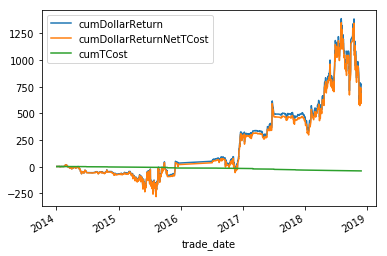

In [17]:
wanke[['cumDollarReturn','cumDollarReturnNetTCost','cumTCost']].plot()

In [18]:
SSE50 = pd.read_csv('index/SSE50.csv')
col = ['trade_date','close','change','pct_chg']
SSE50 = SSE50[col]
SSE50['trade_date'] = SSE50['trade_date'].astype('str').apply(lambda x: datetime.strptime(x, "%Y%m%d"))
SSE50['pct_chg'] = SSE50['pct_chg'].shift(1)
SSE50['change'] = SSE50['change'].shift(1)
SSE50 = SSE50.set_index('trade_date').sort_index().fillna(method='ffill')
SSE50 = SSE50.loc[start:end]
SSE50['transaction_dollar'] = -wanke['transaction']
SSE50['fraction'] = SSE50['transaction_dollar'] / SSE50['close']
SSE50['position'] = SSE50['fraction'].cumsum()
SSE50['dollarReturn'] = SSE50['position'] * SSE50['change']
SSE50['cumDollarReturn'] = SSE50['dollarReturn'].cumsum()
SSE50['tCost'] = SSE50['transaction_dollar'] * tCostRate
SSE50['dollarReturnNetTCost'] = SSE50['dollarReturn'] + SSE50['tCost']
SSE50['cumDollarReturnNetTCost'] = SSE50['dollarReturnNetTCost'].cumsum()


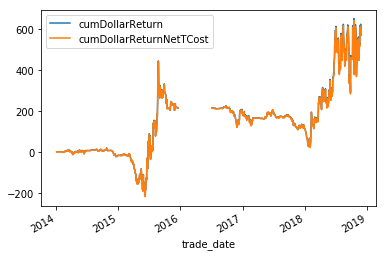

In [19]:
SSE50[['cumDollarReturn','cumDollarReturnNetTCost']].plot()

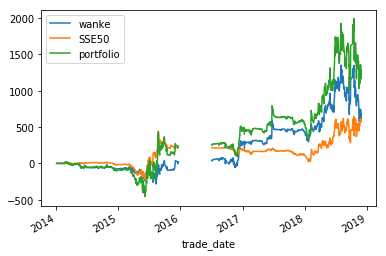

In [20]:
pd.DataFrame({"wanke":wanke['cumDollarReturnNetTCost'], "SSE50":SSE50['cumDollarReturnNetTCost'],"portfolio":wanke['cumDollarReturnNetTCost'] + SSE50['cumDollarReturnNetTCost']}).plot()

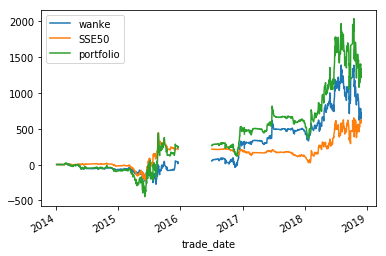

In [21]:
pd.DataFrame({"wanke":wanke['cumDollarReturn'], "SSE50":SSE50['cumDollarReturn'],"portfolio":wanke['cumDollarReturn'] + SSE50['cumDollarReturn']}).plot()